# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [3]:
import random
import torch
import numpy as np
import datetime
from collections import deque
#plot
import matplotlib.pyplot as plt
%matplotlib inline
#Time
import datetime
import time

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
env = UnityEnvironment(file_name='.\Reacher_Windows_x86_64 (1)\Reacher_Windows_x86_64\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    #actions = TrainedActor(states).detach().numpy()
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    #print ('Rewards',rewards),.l
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    #print('Scores' ,scores)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.12999999709427357


In [10]:
#DeepDeterminsticPolicyGradient DDPG
from nn_model import Actor , Critic
from agent import AiAgent

In [14]:
#Test to create the instance of AiAgent
#state_size = np.array(state_size)
reacherAI = AiAgent(state_size,action_size,random_seed=17)
print(reacherAI.actor_local)
print(reacherAI.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=28, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=1, bias=True)
)


In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [12]:
# Deep Determinsitic Policy Gradient Algorithm
# Policy Based -Actor Critic Method

def Ddpg(n_episodes=1000, max_t=300, print_every=100):
    
                            
    rewards_plot = []                          #Final Scores to Plot
    episode_reward=np.zeros(num_agents)        #To save  Episode's Scores
    scores = np.zeros(num_agents)              # Agent(s) Scores 
    scores_window = deque(maxlen=print_every)  #Score Window for every 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        #Reset the Agent and unity Env and score counters for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations  #set initial state
        reacherAI.reset()
        rewards = 0
        episode_reward=np.zeros(num_agents) 
        #For each Episode,  take max steps and record the state and reward information until Episode complete       
        while True: # t in range(max_t):
            
            action = reacherAI.act(state)             #Select action based on policy 
            env_info = env.step(action)[brain_name]   #Perform 'action'
            rewards = env_info.rewards                 #reward +0.1 for every timestep
            next_state = env_info.vector_observations #Next env state info 
            done   = env_info.local_done              #Episode complete
            scores += rewards                         #Accumulate Rewards
            state = next_state                        #mark new state as current state
            episode_reward+=rewards                   #Episode Score
            
                           
            #Store the experience for Replay to make decision - better policy
            if np.any(done):
                reacherAI.step (state, action,scores,next_state,done)
                rewards_plot.append(episode_reward)              #Rewards from each episode
                scores_window.append(episode_reward)             #Print the windows score
                break             
                   
       
        print('Total score (averaged over agents) this episode {}\t: {}'.format(i_episode,np.mean(scores)))  
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage  Score: {:.4f}\t AcScore {:.4f}'.format(i_episode, np.mean(scores_window),np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores)>=30.0 and i_episode >100 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30_23jul.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30_23jul.pth')
            break
              
                   
    return rewards_plot
#Latest23

2020-07-23 15:37:02.600588
Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.05999999865889549
Total score (averaged over agents) this episode 3	: 0.05999999865889549
Total score (averaged over agents) this episode 4	: 0.05999999865889549
Total score (averaged over agents) this episode 5	: 0.05999999865889549
Total score (averaged over agents) this episode 6	: 0.05999999865889549
Total score (averaged over agents) this episode 7	: 0.05999999865889549
Total score (averaged over agents) this episode 8	: 0.05999999865889549
Total score (averaged over agents) this episode 9	: 0.05999999865889549
Total score (averaged over agents) this episode 10	: 0.19999999552965164
Total score (averaged over agents) this episode 11	: 0.19999999552965164
Total score (averaged over agents) this episode 12	: 0.19999999552965164
Total score (averaged over agents) this episode 13	: 0.19999999552965164
Total score (averaged over agents) this episode 1

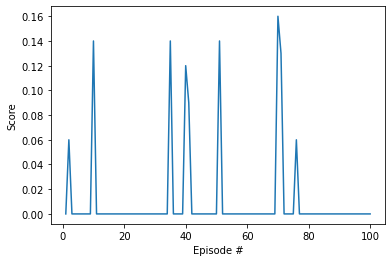

In [15]:
# Iteration Ver 15  - Test run with 100 Episodes
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 500       #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 0.0001        # learning rate of the critic
#WEIGHT_DECAY = 0        # L2 weight decay

#Noise mu=0., theta=0.17, sigma=0.24
#Random seed = 17
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=100)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-23 15:51:48.169165


C:\Users\senth\.conda\envs\drlnd\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.11999999731779099
Total score (averaged over agents) this episode 3	: 0.11999999731779099
Total score (averaged over agents) this episode 4	: 0.11999999731779099
Total score (averaged over agents) this episode 5	: 0.11999999731779099
Total score (averaged over agents) this episode 6	: 0.1699999962002039
Total score (averaged over agents) this episode 7	: 0.1699999962002039
Total score (averaged over agents) this episode 8	: 0.1699999962002039
Total score (averaged over agents) this episode 9	: 0.1699999962002039
Total score (averaged over agents) this episode 10	: 0.1699999962002039
Total score (averaged over agents) this episode 11	: 0.1699999962002039
Total score (averaged over agents) this episode 12	: 0.1699999962002039
Total score (averaged over agents) this episode 13	: 0.1699999962002039
Total score (averaged over agents) this episode 14	: 0.1699999962002039
Total score 

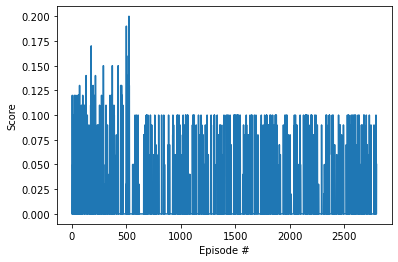

In [16]:
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=5000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

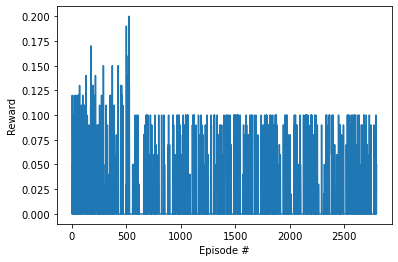

In [18]:
#Episode 100	Average  Score: 0.0214	 AcScore 2.1400
#Episode 200	Average  Score: 0.0146	 AcScore 3.6000
#Episode 300	Average  Score: 0.0107	 AcScore 4.6700
#Episode 400	Average  Score: 0.0124	 AcScore 5.9100
#Episode 500	Average  Score: 0.0124	 AcScore 7.1500
#Episode 600	Average  Score: 0.0113	 AcScore 8.2800
#Episode 700	Average  Score: 0.0110	 AcScore 9.3800
#Episode 800	Average  Score: 0.0067	 AcScore 10.0500
#Episode 900	Average  Score: 0.0049	 AcScore 10.5400
#Episode 1000	Average  Score: 0.0105	 AcScore 11.5900
#Episode 1100	Average  Score: 0.0116	 AcScore 12.7500
#Episode 1200	Average  Score: 0.0102	 AcScore 13.7700
#Episode 1300	Average  Score: 0.0055	 AcScore 14.3200
#Episode 1400	Average  Score: 0.0124	 AcScore 15.5600
#Episode 1500	Average  Score: 0.0121	 AcScore 16.7700
#Episode 1600	Average  Score: 0.0136	 AcScore 18.1300
#Episode 1700	Average  Score: 0.0105	 AcScore 19.1800
#Episode 1800	Average  Score: 0.0110	 AcScore 20.2800
#Episode 1900	Average  Score: 0.0102	 AcScore 21.3000
#Episode 2000	Average  Score: 0.0081	 AcScore 22.1100
#Episode 2100	Average  Score: 0.0094	 AcScore 23.0500
#Episode 2200	Average  Score: 0.0108	 AcScore 24.1300
#Episode 2300	Average  Score: 0.0072	 AcScore 24.8500
#Episode 2400	Average  Score: 0.0104	 AcScore 25.8900
#Episode 2500	Average  Score: 0.0077	 AcScore 26.6600
#Episode 2600	Average  Score: 0.0111	 AcScore 27.7700
#Episode 2700	Average  Score: 0.0121	 AcScore 28.9800
#Total score (averaged over agents) this episode 2798	: 30.01999932900071
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Reward')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Hyperparameters
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 0.00017        # learning rate of the critic
#WEIGHT_DECAY = 0        # L2 weight decay
#Noise mu=0., theta=0.19, sigma=0.24
#Random seed = 1

In [ ]:
#Ver 10.1 22nd Jul

#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 0.00017        # learning rate of the critic
#WEIGHT_DECAY = 0        # L2 weight decay
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=5000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
#backup for Reward plots 
scores_Epi2798 = scores

# Watch the Trained Agent - Loading the weights and Test


In [24]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30_23jul.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30_23jul.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

while True:
    action = reacherAI.act(state, add_noise=True)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  

Total score (averaged over agents) this episode: 0.0


In [ ]:
#Environment Close
env.close()

# History - Trails and more Errors 

##Learnings:
    Sometimes it make us focus in depth understanding and tuning of algos but may miss simple front end part. 
    1. Most common mistake did was not reset the scores 'counter array' so only recent scores scored
    2. Before running long hr training process (like here avg 8 to 10 hrs it took for me to achieve 30+ score' ) please dry run your logic with simple 1 to 10 episodes
    3. After all my 2 extended nights, but got an error on last Printing the time taken so made me restart from point 0 :|
    4. Cud see the OS also matters ...same code , i tried running in Udacity provided workspace (linux) and Windows in my local machines. Same logic but coud see difference in scores average in each episodes. So i tested intial 200 runs to see which seed gets me relatively high score chosen to tune the parameteres
    5. Buffer size can be large but keep the Mini batch - random sampling for correaltions- less than 256
    6. Agent storing history to Replay Memory - its crirtical .. I was oversighted initially by just calling the aiReacher.Step but got right scores by having the condition once the Episode complete with 'done'
    7. Couldn't find much difference using of GPU vs CPU . So completely ran in 'CPU' and saved 'GPU' hrs for next project
    8. Biggest challange is Udacity Workspace have to be active - 3 times got disconnected after 6 hrs and nearing closure all work vanished. Highly recommend try this in Local Machine and once you know what are all the parameters to be tuned after seeing the intial 100 to 300 Episodes then use the parameters in workspace to get it done

In [ ]:
#Episode 100	Average  Score: 2.4100
#Episode 200	Average  Score: 6.0800
#Episode 300	Average  Score: 8.0000


In [ ]:
#Ver 10.1 22nd Jul
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=5000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Ver 10 22nd Jul
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=5000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

1. Episode 100	Average  Score: 0.0599

In [ ]:
#Ver 10 22nd Jul
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=25)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# Deep Determinsitic Policy Gradient Algorithm  # Problem in saving  each episode score for plot  

def Ddpg(n_episodes=1000, max_t=300, print_every=100):
    scores_ddpg = []
    scores = np.zeros(num_agents) 
    scores_window = deque(maxlen=print_every)  #Window for every 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        #set initial state
        state = env_info.vector_observations  #[0] Current state 
        #Reset
        reacherAI.reset()
        score = 0
        reward = 0
       
        
        while True: # t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            
            #action = np.clip(action, -1, 1) #np.clip (0 or 1 )taken care in Agent.Act
            
            #Perform 'action'
            env_info = env.step(action)[brain_name]
            #Next State 
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done   = env_info.local_done
            scores += reward                       
            if done :
                reacherAI.step (state, action,reward,next_state,done)
            
            scores_ddpg.append(reward)
            state = next_state
           
            if np.any(done):
                break
            
        scores_window.append(scores)
        
        #avg_scores.append(np.mean(scores_window))
            
        print('\rEpisode {}\tAverage Score: {:.4f} '.format(i_episode,np.mean(scores)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage  Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores_window)>=30.0 and i_episode >100 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30.pth')
            break
              
                   
    return scores_ddpg


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Ver 9 21st Jul
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)

In [ ]:
#Ver 9 21st Jul
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
scores

# Test Mode using the trained model weights

In [ ]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

for t in range(200):
    action = reacherAI.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  
    

In [ ]:
#Ver 7.3 20th Jul
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Ver 7.2
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Ver 7.1
start = datetime.datetime.now()
print (start)
scores = Ddpg()
endtime = datetime.datetime.now() -start
print (endtime)
fig = plt.figure()3
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Work Logs

In [ ]:
#DDPG ALgo 
gamma = 0.997 
td_steps = 24

def Ddpg(n_episodes=3000, max_t=300, print_every=100):
    start_time = time.time()
    scores = []
    avg_scores = []
    scores_window = deque(maxlen=print_every)  #Window for every 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        #set initial state
        state = env_info.vector_observations  #[0] Current state 
        #Reset
        reacherAI.reset()
        score = 0
        cumlreward = 0
        steps = 0
        ep_scores = np.zeros(num_agents) 
        
        while True: # t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            #action = np.clip(action, -1, 1) #np.clip (0 or 1 )taken care in Agent.Act
            
            #Perform 'action'
            env_info = env.step(action)[brain_name]
            #Next State 
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done   = env_info.local_done
            
            #Discounted Reward
            cumlreward += torch.Tensor(reward).view(-1,1)*gamma**td_steps
            steps +=1
            
            if done or steps ==td_steps:
                #reacherAI.step (state, action,cumlreward,next_state,done)
                [reacherAI.step(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(num_agents)]
                steps = 0
                cumlreward = 0
            
            score += np.mean(reward)
            state = next_state
            #print('\rStep {}\t Current Reward: {:.4f} \t Acu.Score: {:.4f}'.format(i_episode,reward, score))
           
            if np.any(done):
                break
            
        scores_window.append(score)
        scores.append(score)
        avg_scores.append(np.mean(scores_window))
            
        print('\rEpisode {}\tAverage Score: {:.4f} \t Score: {:.4f}'.format(i_episode, np.mean(scores_window),score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Window Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores_window)>=30.0 and i_episode >100 :
            time_taken = time.time() - start_time
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode-100, np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30.pth')
            print ('AiReacher took {} hrs & {} mins to solve the env in {} episodes '.format(int(time_taken/3600),int(time_taken/60,i_episode)))
            break
              
                   
    return scores



Increased Buffer size so Replay Memory size wud be larger but Minibatch to see the correlations reduced to 75
Learning Rate made to .997 
Local to Target Network Sync - updated to 0.017 
Learning rate Actor increased to 0.003 but for critic made it 0.001

theta=0.17, sigma=0.24 - Noise sampling since major challenges cud see during training ..arm is just moving clock wise swing mostly. so need more exploration




In [ ]:
#v6.1 Seed 3 20 Agents just a try  Batch Size
start = datetime.datetime.now()
print (start)
scores = Ddpg()
endtime = datetime.datetime.now() -start
print (endtime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#v5.1 Seed 3 Batch Size
start = datetime.datetime.now()
print (start)
scores = Ddpg()
endtime = datetime.datetime.now() -start
print (endtime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
print (endtime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

BUFFER_SIZE = 50000    #int(1e4)  # replay buffer size
BATCH_SIZE = 480        #128        # minibatch size
GAMMA = 0.978            # discount factor
TAU = 0.002              # for soft update of target parameters
LR_ACTOR = 0.001         # learning rate of the actor 
LR_CRITIC =0.001        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay


In [ ]:
#v4.1 Seed 3 Batch Size
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#v3.1 Seed 786 Batch Size
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#v2.1 Seed 9 Batch Size
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#param
BUFFER_SIZE = 100000    #int(1e4)  # replay buffer size
BATCH_SIZE = 240        #128        # minibatch size
GAMMA = 0.978            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 0.0001         # learning rate of the actor 
LR_CRITIC =0.0001        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay


In [ ]:
V3.1 - 10000 Episodes
BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
BATCH_SIZE = 240        #128        # minibatch size
GAMMA = 0.978            # discount factor
TAU = 0.0017              # for soft update of target parameters
LR_ACTOR = 0.0001         # learning rate of the actor 
LR_CRITIC =0.0001        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

Seed =9

In [ ]:
n_episodes
#v3.1 Seed 9 
scores = Ddpg(n_episodes=10000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()

In [ ]:
a = np.array(state_size)
a
t=torch.from_numpy(a)
a
state = torch.from_numpy(np.array(state_size)).to('cpu')
state

In [ ]:
type(state_size)

When finished, you can close the environment.

In [ ]:
print (torch.__version__)

In [ ]:
# Deep Determinsitic Policy Gradient Algorithm

def Ddpg(n_episodes=5000, max_t=300, print_every=100):
    
    scores_ddpg = []                           #Final Scores to Plot
    scores = np.zeros(num_agents)              #Reward for the Episodes reset
    scores_window = deque(maxlen=print_every)  #Window for every 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        #set initial state
        state = env_info.vector_observations  #[0] Current state 
        #Reset
        reacherAI.reset()
        rewards = 0
        
        
        #For each Episode,  take max steps and record the state and reward information until Episode complete       
        while True: # t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            #action = np.clip(action, -1, 1) #np.clip (0 or 1 )taken care in Agent.Act
            
           
            env_info = env.step(action)[brain_name]   #Perform 'action'
            next_state = env_info.vector_observations #Next env state info 
            
            rewards = env_info.rewards                 #reward +0.1 for every timestep
            done   = env_info.local_done              #Episode complete
            scores += rewards                          #Accumulate Rewards
            state = next_state                        #mark new state as current state
            scores_ddpg.append(rewards)               #Actual Reward from this Episode to be returned
            #Store the experience for Replay to make decision - better policy
            if np.any(done):
                reacherAI.step (state, action,scores,next_state,done)
                 
                break             
           
        scores_window.append(scores)                  #Print the windows score
       
        print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  
        
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage  Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores)>=10.0 and i_episode >1 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30.pth')
            break
              
                   
    return scores_ddpg


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```